<a href="https://colab.research.google.com/github/Rahul-Verma97/BE-Paper/blob/master/VNF_scaling_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import sklearn.preprocessing as skp 
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, callbacks
from keras.layers import Dense, LSTM, Dropout, GRU,Conv1D
def plot_series(time, series, format="-", start=0, end=None, color = None):
    plt.plot(time[start:end], series[start:end], format, color = color)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [180]:
def load_client_dataset(client_id,datasetno):
  datapath='/content/drive/MyDrive/Materna/GWA-T-13_Materna-Workload-Traces/Materna-Trace-'+str(datasetno)+'/'
  #print('------------------------ Loading client-'+ str(client_id) +'train dataset ------------------------')
  if client_id<10:
    df=pd.read_csv(datapath+"/0"+str(client_id)+".csv", sep=';')
  else:
    df=pd.read_csv(datapath+str(client_id)+".csv", sep=';',on_bad_lines='skip')
  return df
def load_data():
  dff = load_client_dataset(1,1)
  for datano in range(1,4):
    for client_id in range(1,2):
      if client_id > 0:
        dff=dff.append(load_client_dataset(client_id,datano))
        print('################################## Loaded Client:'+ str(client_id) +' Data ##################################')
  return dff


In [181]:
df1=load_data()
# df1['Memory usage [%]'] = df1['Memory usage [%]'].str.replace(',','.')
# df1['Memory usage [%]'] = df1['Memory usage [%]'].astype(float, errors = 'raise')
df1['CPU usage [%]'] = df1['CPU usage [%]'].str.replace(',','.')
df1['CPU usage [%]'] = df1['CPU usage [%]'].astype(float, errors = 'raise')
df1["CPU usage [%]"] = df1["CPU usage [%]"] + 50
df1['CPU usage [%]'].values[df1['CPU usage [%]'] > 100] = 100
df = pd.DataFrame()
df["Q1"]=df1["CPU usage [%]"]
# df["Q3"]=df1["Memory usage [%]"]
df.describe()

################################## Loaded Client:1 Data ##################################
################################## Loaded Client:1 Data ##################################
################################## Loaded Client:1 Data ##################################


,Q1
count,35990.000000
mean,62.912076
std,19.228406
min,51.960000
25%,52.540000
50%,52.980000
75%,53.870000
max,100.000000


In [182]:
from sklearn.preprocessing import MinMaxScaler
input_feature= df.values
input_data = input_feature
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,:] = sc.fit_transform(input_feature[:,:])
lookback=50
train_size=int(.8 * len(input_data))
X_i=[]
y_i=[]
for i in range(len(input_data)-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    X_i.append(t)
    y_i.append(input_data[i+ lookback,:])
X_i, y_i= np.array(X_i), np.array(y_i)
X=X_i[:train_size]
y=y_i[:train_size]
X_test = X_i[train_size:]
X = X.reshape(X.shape[0],lookback, 1)
X_test = X_test.reshape(X_test.shape[0],lookback,1)
print(X.shape)
print(X_test.shape)
y_test=y_i[train_size:]


(28792, 50, 1)
(7147, 50, 1)


In [183]:
from keras import Sequential
from keras.layers import Dense, LSTM

In [184]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],1)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 50, 30)            3840      
                                                                 
 lstm_27 (LSTM)              (None, 50, 30)            7320      
                                                                 
 lstm_28 (LSTM)              (None, 30)                7320      
                                                                 
 dense_9 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trainable params: 0
_________________________________________________________________


In [185]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [186]:
model.fit(X, y, epochs=18, batch_size=32)


Epoch 1/18
900/900 [==============================] - 62s 35ms/step - loss: 0.0030
Epoch 2/18
900/900 [==============================] - 31s 34ms/step - loss: 0.0013
Epoch 3/18
900/900 [==============================] - 31s 34ms/step - loss: 9.3319e-04
Epoch 4/18
900/900 [==============================] - 31s 34ms/step - loss: 7.7289e-04
Epoch 5/18
900/900 [==============================] - 31s 34ms/step - loss: 7.3559e-04
Epoch 6/18
900/900 [==============================] - 31s 34ms/step - loss: 6.8534e-04
Epoch 7/18
900/900 [==============================] - 31s 34ms/step - loss: 6.7774e-04
Epoch 8/18
900/900 [==============================] - 31s 34ms/step - loss: 6.8430e-04
Epoch 9/18
900/900 [==============================] - 31s 34ms/step - loss: 6.6978e-04
Epoch 10/18
900/900 [==============================] - 31s 34ms/step - loss: 6.6492e-04
Epoch 11/18
900/900 [==============================] - 31s 34ms/step - loss: 6.6279e-04
Epoch 12/18
900/900 [============================

In [187]:
predicted_value= model.predict(X_test)


In [188]:
predicted_value.shape

(7147, 1)

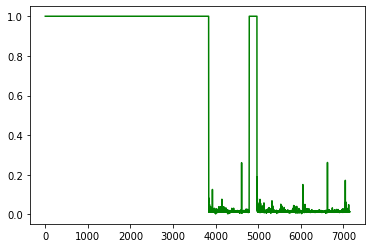

In [221]:
plt.plot(y_test, color='green')


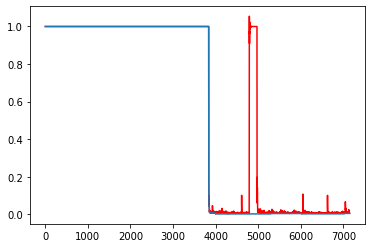

In [232]:
plt.plot(predicted_value, color= 'red')
plt.plot(np.array(newdf))

In [234]:
newdf = pd.DataFrame(predicted_value)
newdf1 = pd.DataFrame(predicted_value)
newdf=newdf[0].rolling(100,min_periods=1).min()
newdf1=newdf1[0].rolling(100,min_periods=1).max()
# newdf1=newdf[0].rolling(1000,min_periods=1).min()

# newdf.rolling(3, win_type ='triang',min_periods=1).min()


In [212]:
newdf

0       False
1       False
2        True
3        True
4        True
        ...  
7142     True
7143    False
7144    False
7145     True
7146     True
Name: 0, Length: 7147, dtype: bool

In [209]:
newdf = newdf[0].rolling(window =3).min() ==newdf[0]


In [ ]:
plt.plot(predicted_value[:,0], color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),0], color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

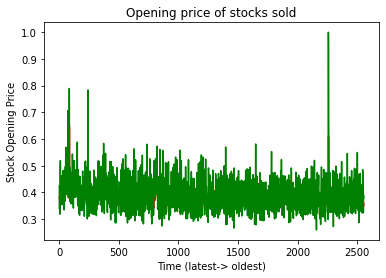

In [112]:
plt.plot(predicted_value[:,1], color= 'red')
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

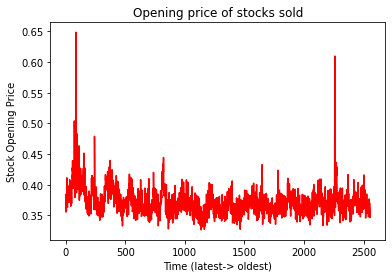

In [114]:
plt.plot(predicted_value[:,1], color= 'red')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

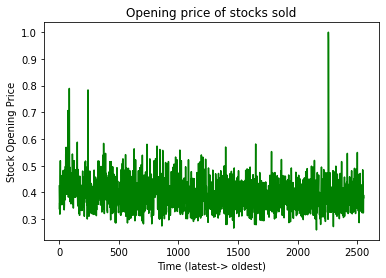

In [115]:
plt.plot(input_data[lookback:test_size+(2*lookback),1], color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

In [67]:
predwindow=2
no_of_feature=1
from sklearn.preprocessing import MinMaxScaler
def preprocess(df,window):
    input_feature= df.values
    input_data = input_feature
    sc= MinMaxScaler(feature_range=(0,1))
    input_data[:,0:no_of_feature] = sc.fit_transform(input_feature[:,:])
    lookback=window
    train_size=int(.8 * len(input_data)/2)
    X_i=[]
    y_i=[]
    for i in range(0,len(input_data)-lookback-1,predwindow):
      t=[]
      for j in range(0,lookback):

          t.append(input_data[[(i+j)], :])
      X_i.append(t)
    for i in range(0,len(input_data)-lookback-1,predwindow):
      t=[]
      for j in range(0,predwindow):

          t.append(input_data[[(i+j+lookback)], :])
      y_i.append(t)
    X_i, y_i= np.array(X_i), np.array(y_i)
    X=X_i[:train_size]
    y=y_i[:train_size]
    X_test = X_i[train_size:]
    X = X.reshape(X.shape[0],lookback, no_of_feature)
    X_test = X_test.reshape(X_test.shape[0],lookback, no_of_feature)
    y = y.reshape(y.shape[0],predwindow, no_of_feature)
    print(X.shape)
    print(y.shape)
    print(X_test.shape)
    y_test=y_i[train_size:]
    y_test = y_test.reshape(y_test.shape[0],predwindow, no_of_feature)
    return X,y,X_test,y_test


In [68]:
MAX_EPOCHS =50
def compile_and_fit(model, dataset, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.losses.Huber(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(dataset, epochs=MAX_EPOCHS,
                      callbacks=[early_stopping])
  return history

In [69]:

def lstm(units,X):
    tf.keras.backend.clear_session()
    model = Sequential()
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],no_of_feature)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.add(
    LSTM(units = 60, return_sequences=True, 
    input_shape=(X.shape[1],no_of_feature)))
    model.add(LSTM(units = 60))
    model.add(Dense(units=no_of_feature*predwindow))
    model.add(tf.keras.layers.Reshape([predwindow, no_of_feature]))
    return model
def gru(units,X):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(GRU (units = 60, return_sequences = True, 
    input_shape = (X.shape[1],no_of_feature)))
    model.add(GRU(units = 60)) 
    model.add(Dense(units=no_of_feature*predwindow))
    model.add(tf.keras.layers.Reshape([predwindow, no_of_feature]))
    return model

In [70]:
import os
path='/content/drive/MyDrive/VNFscalingresult'
os.makedirs(path,exist_ok=True)

def plot_multi_step(history, prediction1, prediction2,obs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
# #     plt.figure(figsize=(15, 6))
#     for i in range(0,3):
    range_history = len(history[:,0])
    l1 = ax1.plot(np.arange(range_history), np.array(history[:,0]), 
             label='History')
    l1= ax1.plot(np.arange(range_history), np.array(prediction1[:,0]),
             label='Forecasted for GRU')
    l1 = ax1.plot(np.arange(range_history), np.array(prediction2[:,0]),
             label='Forecasted for LSTM')
    ax1.set_ylabel('Q1')
    ax1.set_xlabel('Time')
    fig.legend(
           loc="upper right")
    # l2 = ax2.plot(np.arange(range_history), np.array(history[:,1]), 
    #          label='History')
    # l2= ax2.plot(np.arange(range_history), np.array(prediction1[:,1]),
    #          label='Forecasted for GRU')
    # l2 = ax2.plot(np.arange(range_history),np.array(prediction2[:,1]),
    #          label='Forecasted for Bidrectional_LSTM')
    # l2= ax2.plot(np.arange(range_history), np.array(prediction3[:,1]),
    #          label='Forecasted for LSTM')
    # ax2.set_ylabel('Q2')
    # ax2.set_xlabel('Time')
    plt.savefig(path+"/"+"Observation Window:"+str(obs)+"Predication Comparision.pdf",format="pdf")

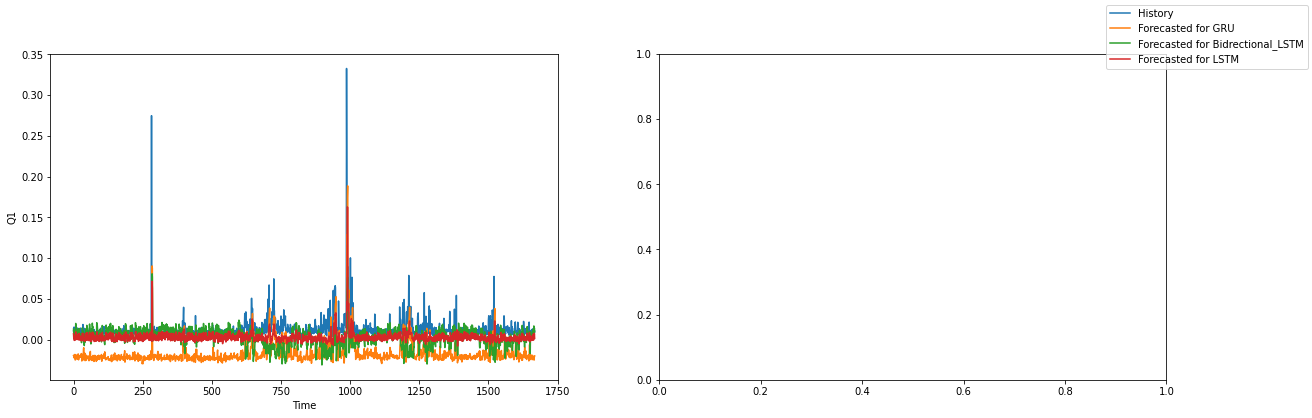

In [63]:
 plot_multi_step(y_test,predicted_gru, predicted_bilstm,predicted_value,obsv_win_len)

(3340, 12, 1)
(3340, 2, 1)
(830, 12, 1)
Epoch 1/50
105/105 [==============================] - 12s 19ms/step - loss: 0.0163 - mean_absolute_error: 0.0721
Epoch 2/50
105/105 [==============================] - 2s 19ms/step - loss: 0.0129 - mean_absolute_error: 0.0674
Epoch 3/50
105/105 [==============================] - 2s 19ms/step - loss: 0.0088 - mean_absolute_error: 0.0583
Epoch 4/50
105/105 [==============================] - 2s 19ms/step - loss: 0.0097 - mean_absolute_error: 0.0571
Epoch 5/50
105/105 [==============================] - 2s 19ms/step - loss: 0.0045 - mean_absolute_error: 0.0387
Epoch 6/50
105/105 [==============================] - 2s 19ms/step - loss: 0.0023 - mean_absolute_error: 0.0237
Epoch 7/50
105/105 [==============================] - 2s 19ms/step - loss: 0.0022 - mean_absolute_error: 0.0215
Epoch 8/50
105/105 [==============================] - 2s 18ms/step - loss: 0.0025 - mean_absolute_error: 0.0242
Epoch 9/50
105/105 [==============================] - 2s 18ms/s

INFO:tensorflow:Assets written to: /content/drive/MyDrive/VNFscalingmodel/12/SDF_bilstm_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/VNFscalingmodel/12/SDF_bilstm_model/assets


26/26 [==============================] - 3s 7ms/step - loss: 5.3894e-04 - mean_absolute_error: 0.0297
Epoch 1/50
105/105 [==============================] - 5s 11ms/step - loss: 0.0116 - mean_absolute_error: 0.0709
Epoch 2/50
105/105 [==============================] - 1s 10ms/step - loss: 0.0088 - mean_absolute_error: 0.0543
Epoch 3/50
105/105 [==============================] - 1s 10ms/step - loss: 0.0026 - mean_absolute_error: 0.0314
Epoch 4/50
105/105 [==============================] - 1s 10ms/step - loss: 0.0034 - mean_absolute_error: 0.0385
Epoch 5/50
105/105 [==============================] - 1s 10ms/step - loss: 0.0051 - mean_absolute_error: 0.0468
Epoch 6/50
105/105 [==============================] - 1s 10ms/step - loss: 0.0039 - mean_absolute_error: 0.0402


INFO:tensorflow:Assets written to: /content/drive/MyDrive/VNFscalingmodel/12/SDF_gru_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/VNFscalingmodel/12/SDF_gru_model/assets


26/26 [==============================] - 1s 5ms/step - loss: 9.6719e-05 - mean_absolute_error: 0.0049
Epoch 1/50
105/105 [==============================] - 5s 11ms/step - loss: 0.0168 - mean_absolute_error: 0.0776
Epoch 2/50
105/105 [==============================] - 1s 11ms/step - loss: 0.0206 - mean_absolute_error: 0.0912
Epoch 3/50
105/105 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_absolute_error: 0.0342
Epoch 4/50
105/105 [==============================] - 1s 11ms/step - loss: 0.0068 - mean_absolute_error: 0.0455
Epoch 5/50
105/105 [==============================] - 1s 11ms/step - loss: 0.0029 - mean_absolute_error: 0.0242
Epoch 6/50
105/105 [==============================] - 1s 11ms/step - loss: 0.0027 - mean_absolute_error: 0.0231
Epoch 7/50
105/105 [==============================] - 1s 11ms/step - loss: 0.0027 - mean_absolute_error: 0.0244
Epoch 8/50
105/105 [==============================] - 1s 11ms/step - loss: 0.0039 - mean_absolute_error: 0.0330
Ep

INFO:tensorflow:Assets written to: /content/drive/MyDrive/VNFscalingmodel/12/SDF_lstm_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/VNFscalingmodel/12/SDF_lstm_model/assets


26/26 [==============================] - 1s 5ms/step - loss: 2.2794e-04 - mean_absolute_error: 0.0165
BI_LSTM     : 0.0297
GRU         : 0.0049
LSTM        : 0.0165
(3340, 18, 1)
(3340, 2, 1)
(827, 18, 1)
Epoch 1/50
105/105 [==============================] - 10s 23ms/step - loss: 0.0250 - mean_absolute_error: 0.0862
Epoch 2/50
105/105 [==============================] - 2s 23ms/step - loss: 0.0252 - mean_absolute_error: 0.0864
Epoch 3/50
105/105 [==============================] - 2s 23ms/step - loss: 0.0134 - mean_absolute_error: 0.0611
Epoch 4/50
105/105 [==============================] - 2s 24ms/step - loss: 0.0039 - mean_absolute_error: 0.0288
Epoch 5/50
105/105 [==============================] - 2s 24ms/step - loss: 0.0050 - mean_absolute_error: 0.0329
Epoch 6/50
105/105 [==============================] - 2s 24ms/step - loss: 0.0073 - mean_absolute_error: 0.0449
Epoch 7/50
105/105 [==============================] - 2s 24ms/step - loss: 0.0023 - mean_absolute_error: 0.0191
Epoch 8/50

INFO:tensorflow:Assets written to: /content/drive/MyDrive/VNFscalingmodel/18/SDF_bilstm_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/VNFscalingmodel/18/SDF_bilstm_model/assets


26/26 [==============================] - 2s 9ms/step - loss: 1.1292e-04 - mean_absolute_error: 0.0069
Epoch 1/50
105/105 [==============================] - 5s 12ms/step - loss: 0.0110 - mean_absolute_error: 0.0655
Epoch 2/50
105/105 [==============================] - 1s 12ms/step - loss: 0.0057 - mean_absolute_error: 0.0430
Epoch 3/50
105/105 [==============================] - 1s 12ms/step - loss: 0.0039 - mean_absolute_error: 0.0415
Epoch 4/50
105/105 [==============================] - 1s 13ms/step - loss: 0.0122 - mean_absolute_error: 0.0712
Epoch 5/50
105/105 [==============================] - 1s 12ms/step - loss: 0.0019 - mean_absolute_error: 0.0324
Epoch 6/50
105/105 [==============================] - 1s 12ms/step - loss: 0.0022 - mean_absolute_error: 0.0313
Epoch 7/50
105/105 [==============================] - 1s 12ms/step - loss: 0.0020 - mean_absolute_error: 0.0296
Epoch 8/50
105/105 [==============================] - 1s 12ms/step - loss: 0.0018 - mean_absolute_error: 0.0280
Ep

INFO:tensorflow:Assets written to: /content/drive/MyDrive/VNFscalingmodel/18/SDF_gru_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/VNFscalingmodel/18/SDF_gru_model/assets


26/26 [==============================] - 1s 6ms/step - loss: 1.5229e-04 - mean_absolute_error: 0.0125
Epoch 1/50
105/105 [==============================] - 7s 13ms/step - loss: 0.0190 - mean_absolute_error: 0.0795
Epoch 2/50
105/105 [==============================] - 1s 13ms/step - loss: 0.0227 - mean_absolute_error: 0.0928
Epoch 3/50
105/105 [==============================] - 1s 13ms/step - loss: 0.0068 - mean_absolute_error: 0.0489
Epoch 4/50
105/105 [==============================] - 2s 15ms/step - loss: 0.0061 - mean_absolute_error: 0.0437
Epoch 5/50
105/105 [==============================] - 2s 18ms/step - loss: 0.0030 - mean_absolute_error: 0.0273
Epoch 6/50
105/105 [==============================] - 2s 22ms/step - loss: 0.0028 - mean_absolute_error: 0.0254
Epoch 7/50
105/105 [==============================] - 2s 17ms/step - loss: 0.0030 - mean_absolute_error: 0.0267
Epoch 8/50
105/105 [==============================] - 2s 16ms/step - loss: 0.0032 - mean_absolute_error: 0.0287
Ep

INFO:tensorflow:Assets written to: /content/drive/MyDrive/VNFscalingmodel/18/SDF_lstm_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/VNFscalingmodel/18/SDF_lstm_model/assets


26/26 [==============================] - 1s 5ms/step - loss: 2.9088e-04 - mean_absolute_error: 0.0199
BI_LSTM     : 0.0069
GRU         : 0.0125
LSTM        : 0.0199


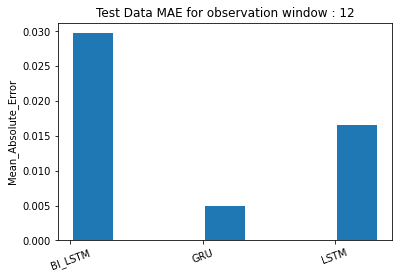

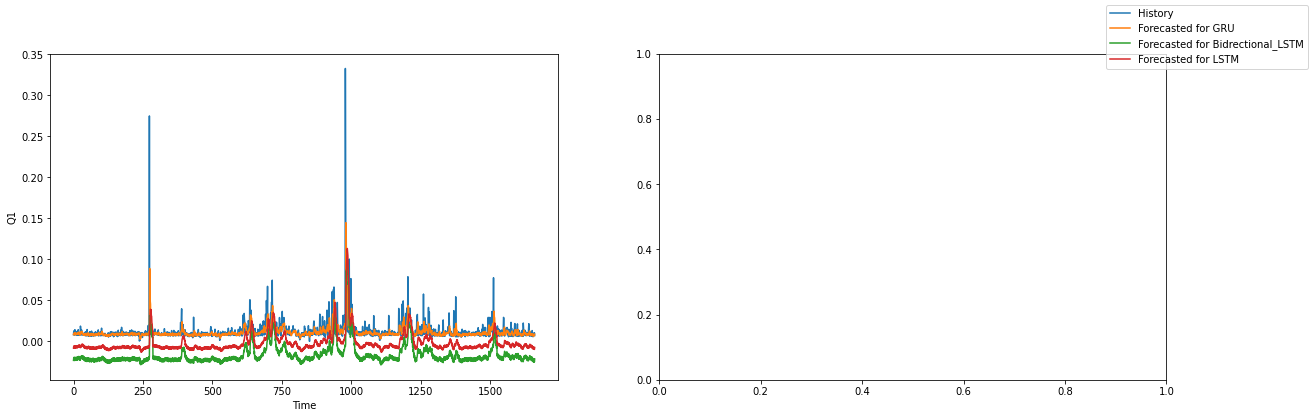

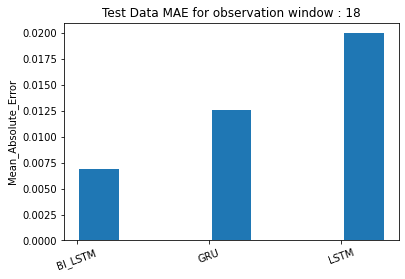

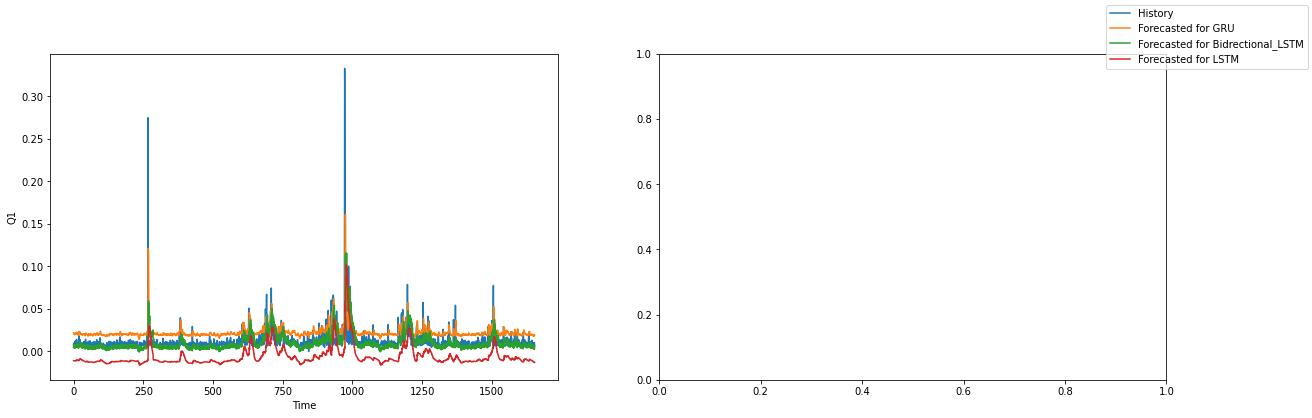

In [73]:
multi_performance={}
units=32
dict1={}
# dict1['Dense']=[]
dict1['BI_LSTM']=[]
dict1['GRU']=[]
dict1['LSTM']=[]
# obsv_win_lens=[48]
obsv_win_lens=[12,18]
table =[]
newpath='/content/drive/MyDrive/VNFscalingmodel/'
os.makedirs(path,exist_ok=True)
base_model_dir=newpath
columns = tuple(obsv_win_lens)
rows = ("CNN", "BI_LSTM", "GRU", "LSTM")[::-1]
for obsv_win_len in obsv_win_lens:
    tf.keras.backend.clear_session()
    # print(obsv_win_len)
    df1=load_data()
    df1['Memory usage [%]'] = df1['Memory usage [%]'].str.replace(',','.')
    df1['Memory usage [%]'] = df1['Memory usage [%]'].astype(float, errors = 'raise')
    df1['CPU usage [%]'] = df1['CPU usage [%]'].str.replace(',','.')
    df1['CPU usage [%]'] = df1['CPU usage [%]'].astype(float, errors = 'raise')
    df1["CPU usage [%]"] = df1["CPU usage [%]"] + 50
    df1['CPU usage [%]'].values[df1['CPU usage [%]'] > 100] = 100
    df = pd.DataFrame()
    df["Q2"]=df1["CPU usage [%]"]
    # df["Q3"]=df1["Memory usage [%]"]
    df.describe()
    model_dir = base_model_dir + str(obsv_win_len) + '/' 
    os.makedirs(model_dir, exist_ok=True)
    X,y,X_test,y_test=preprocess(df,obsv_win_len)
    dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(32)
    datasettest = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(32)
    bilstm_model=bilstm(units,X)
    history = compile_and_fit(bilstm_model,dataset)
    model_name = 'SDF_' + "bilstm_model" 
    model_path = os.path.join(model_dir, model_name)
    bilstm_model.save(model_path)
    multi_performance['BI_LSTM'] =bilstm_model.evaluate(datasettest)
    gru_model=gru(units,X)
    history = compile_and_fit(gru_model,dataset)
    model_name = 'SDF_' + "gru_model" 
    model_path = os.path.join(model_dir, model_name)
    gru_model.save(model_path)
    multi_performance['GRU'] =gru_model.evaluate(datasettest)
    lstm_model=lstm(units,X)
    history = compile_and_fit(lstm_model,dataset)
    model_name = 'SDF_' + "lstm_model" 
    model_path = os.path.join(model_dir, model_name)
    lstm_model.save(model_path)
    multi_performance['LSTM'] =lstm_model.evaluate(datasettest)
    x = np.arange(len(multi_performance))
    width = 0.3
    metric_name = 'mean_absolute_error'
    metric_index =lstm_model.metrics_names.index('mean_absolute_error')
    test_mae = [v[metric_index] for v in multi_performance.values()]
    plt.figure()
    plt.clf()
    plt.ylabel('Mean_Absolute_Error')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.xticks(ticks=x, labels=multi_performance.keys(),
          rotation=20)
    plt.title("Test Data MAE for observation window : "+str(obsv_win_len))
    plt.savefig(path+"/"+"Observation Window:"+str(obsv_win_len)+"ALGORITHM_BARPLOT.pdf",format="pdf")
    reslst=[]
    for name, value in multi_performance.items():
      print(f'{name:12s}: {value[1]:0.4f}')
      val=value[1]
      dict1[str(name)].append(val)
      reslst.append(val)
      
    predicted_value= lstm_model.predict(X_test)
    predicted_bilstm= bilstm_model.predict(X_test)
    predicted_gru= gru_model.predict(X_test)
    predicted_value= predicted_value.reshape(-1,no_of_feature)
    predicted_bilstm=predicted_bilstm.reshape(-1,no_of_feature)
    predicted_gru= predicted_gru.reshape(-1,no_of_feature)
    y_test=y_test.reshape(-1,no_of_feature)
    reslst = [ '%0.4f' % reslst for reslst in reslst ]
    table.append(reslst)
    plot_multi_step(y_test,predicted_gru,predicted_value,obsv_win_len)